In [28]:
import logging
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import math
import re

logger = logging.getLogger(__name__)

In [29]:
# Step 1: Load data from parquet files to a dataframe and explore

dir_path = "./challenge"  # Replace with your directory path

dir_path = Path(dir_path)

# Use glob to find all .parquet files
files = sorted(dir_path.glob("*.parquet"))
logger.info(f"Loading {len(files)} parquet files from {dir_path}")

# Load files with tracking of any failed files
dataframes = []
failed_files = 0

for file in files:
    # Read individual parquet file. By default, pandas uses PyArrow if installed.
    df_individual = pd.read_parquet(file)
    # Append to list of DataFrames
    dataframes.append(df_individual)

# Efficiently concatenate DataFrames
df = pd.concat(dataframes, ignore_index=True, copy=False)
logger.info(f"Loaded {len(df):,} rows from {len(dataframes)} files")

df

,item_code,product_name,attribute_key,attribute_language,attribute_key_local,attribute_value,attribute_value_local
0,000000001000452696,3-Sitzer Sofa HANKS,abrasionResistanceCover1,de,Scheuerbeständigkeit,35000abrasionRuns,35.000 Scheuertouren
1,000000001000452696,3-Sitzer Sofa HANKS,armrests,de,Armlehnen,witharmrests,Mit Armlehnen
2,000000001000452696,3-Sitzer Sofa HANKS,aroundCover,de,Rundumbezug,withAroundCover,Mit Rundumbezug
3,000000001000452696,3-Sitzer Sofa HANKS,backrestHeight,de,Rückenlehnenhöhe,40,40
4,000000001000452696,3-Sitzer Sofa HANKS,capacityKG,de,Belastbarkeit,120,120
...,...,...,...,...,...,...,...
271072,000000001000476894,Sofaelement 1-Sitzer ALON mit Lehne,frameUpholstery,de,Gestell,covered,Bezogen
271073,000000001000476894,Sofaelement 1-Sitzer ALON mit Lehne,guarantee,de,Garantie (Jahre),2,2
271074,000000001000476894,Sofaelement 1-Sitzer ALON mit Lehne,lightFastnessCover1,de,Lichtbeständigkeit,4relativelyWell,4 = ziemlich
271075,000000001000476894,Sofaelement 1-Sitzer ALON mit Lehne,textileCompositionCover1,de,Stoffzusammensetzung Bezug,100% Polyester,100% Polyester


In [30]:
df.describe()

,item_code,product_name,attribute_key,attribute_language,attribute_key_local,attribute_value,attribute_value_local
count,271077,271077,271077,271077,271077,271077,271077
unique,9771,7102,255,1,237,33297,32975
top,000000001000473434,Polsterbett KINX,material,de,Farbe,0,0
freq,110,1611,14009,271077,32186,8823,8823


In [40]:
# Step 2: Processing the data (transforming and statistics)

# Step 2.1: make the item_code column unique and pivot attribute keys to columns
_values_col = 'attribute_value_local' 

_tmp = df[['item_code', 'attribute_key', _values_col]].drop_duplicates()

_attr_wide = (
    _tmp.pivot_table(
        index='item_code',
        columns='attribute_key',
        values=_values_col,
        aggfunc='first'
    ).rename_axis(None, axis=1)
)

_names = (
    df[['item_code', 'product_name']]
      .drop_duplicates()
      .groupby('item_code', as_index=True)['product_name']
      .first()
      .to_frame()
)

df_wide = _names.join(_attr_wide).reset_index()

df_wide


,item_code,product_name,_depth_height,_lyingSurfaceLength_lyingSurfaceWidth,_width_depth,_width_height,_width_height_depth,abrasionResistanceCover1,adventCalenderDesign,amountChairs,...,weight,weightCapacity,weightCapacityDrawers,width,widthArmrests,widthLongchair,widthSeatElement,widthStool,wood,zipperType
0,000000001000000262,Wandleuchte Sally- Metall/Glas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.27,NaN,NaN,82,NaN,NaN,NaN,NaN,NaN,NaN
1,000000001000000450,Deckenleuchte Loona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000001000001965,Glas-Pendelleuchte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.8,NaN,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN
3,000000001000001975,Porzellan-Pendelleuchte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000001000002535,Deckenleuchten Balken II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.9,NaN,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9766,000000003001604996,Spielzelt 3013992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.56,NaN,NaN,120,NaN,NaN,NaN,NaN,NaN,NaN
9767,000000003001605008,Spielzelt 93680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.15,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN
9768,000000003001605792,Delfin Spielzeug 296178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
9769,000000003001605862,Esszimmerstuhl drehbar Jelena(6er Set),NaN,NaN,NaN,NaN,NaN,NaN,NaN,6er Set,...,57,NaN,NaN,59,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Step 2.2: Drop columns with more than 60% NaN values

threshold = 0.50  # proportion of NaN allowed (strictly greater than this will be dropped)

# Columns we never drop
protected_cols = {"item_code", "product_name"}

# Calculate NaN ratio per column
nan_ratio = df_wide.isna().mean()

# Identify columns to drop (exclude protected ones)
cols_to_drop = [
    c for c, r in nan_ratio.items()
    if r > threshold and c not in protected_cols
]

print(f"Total columns including protected ones: {len(df_wide.columns)}")
print(f"Columns to drop (> {threshold:.0%} NaN): {len(cols_to_drop)}")

# Show a small sample if many
sample_list = cols_to_drop[:15]
print("Sample to drop:", sample_list, "..." if len(cols_to_drop) > len(sample_list) else "")

# Apply dropping
if cols_to_drop:
    df_wide = df_wide.drop(columns=cols_to_drop)

print(f"New shape: {df_wide.shape}")
print(f"candidate attribute columns: {len(df_wide.columns) - len(protected_cols)}")

# Keep a record of dropped columns for later reference
dropped_columns_over_60pct_nan = cols_to_drop

# Display resulting dataframe
df_wide

Total columns including protected ones: 257
Columns to drop (> 50% NaN): 240
Sample to drop: ['_depth_height', '_lyingSurfaceLength_lyingSurfaceWidth', '_width_depth', '_width_height', '_width_height_depth', 'abrasionResistanceCover1', 'adventCalenderDesign', 'amountChairs', 'amountOfCushions', 'amountPiecesSupplierSet', 'amountSlatsPlates', 'armrestHeight', 'armrests', 'aroundCover', 'assembly'] ...
New shape: (9771, 17)
candidate attribute columns: 15


,item_code,product_name,color,colorDetail,colorSubcolor,deliveryScope,depth,dimensionDetail,hasElectricItem,height,material,materialDetail,name,shippingCondition,styleFilter,weight,width
0,000000001000000262,Wandleuchte Sally- Metall/Glas,Silber,"Hauptfarbe: Silber, Weiß Sekundärfarbe: Weiß",NaN,NaN,15,Breite: 82 cm Gewicht: 1.27 kg Höhe variabel: ...,1,NaN,Glas,Hauptmaterial: Metall Sekundärmaterial Glas,Wandleuchte Sally- Metall/Glas - Weiß - 4-flammig,Montiert,Modern,1.27,82
1,000000001000000450,Deckenleuchte Loona,Silber,Gestell: Silber,NaN,NaN,14,Durchmesser: 19 cm Gewicht: 0.64 kg Höhe varia...,1,NaN,Metall,Gestell: Edelstahl,Deckenleuchte Loona - 3-flammig,Montiert,Modern,0.64,NaN
2,000000001000001965,Glas-Pendelleuchte,Multicolor,NaN,NaN,NaN,8,"Höhe 110cm, Breite 41cm, Tiefe 8cm",1,110,Glas,"Metall, Glas",Glas-Pendelleuchte - Metall - Schwarz,NaN,Andere,1.8,41
3,000000001000001975,Porzellan-Pendelleuchte,Weiß,NaN,NaN,NaN,NaN,"Höhe 21cm, Durchmesser 29cm",1,21,Keramik,Porzellan,Porzellan-Pendelleuchte - Weiß - Keramik - Ste...,NaN,Modern,1.8,NaN
4,000000001000002535,Deckenleuchten Balken II,Silber,Nickel,NaN,NaN,9,Breite: 48 cm Gewicht: 0.9 kg Höhe: 15 cm Tief...,1,15,Metall,Metall,Deckenleuchten Balken II - Nickel - 3 flammig,Montiert,Modern,0.9,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9766,000000003001604996,Spielzelt 3013992,Grau,"Grau, Hellgrün, Weiß",Grau,"1 x Spielzelt & 550 x Ball (Gelb, Blau, Rot, W...",123,Breite: 120 cm Gewicht: 3.56 kg Höhe: 126 cm T...,0,126,Metall,"Material: Metall, Textil Metallart: Stahl Stof...",Spielzelt 3013992 - Grau - Grün - Weiß - Polye...,Zerlegt,NaN,3.56,120
9767,000000003001605008,Spielzelt 93680,Pink,Pink,Pink,1 x Spielzelt & 1 x Tragetasche,100,Breite: 100 cm Gewicht: 1.15 kg Höhe: 127 cm T...,0,127,Textil,Material: Textil Stoffart: Polyester,Spielzelt 93680 - Pink - Polyester - 100 x 127...,Teilmontiert,NaN,1.15,100
9768,000000003001605792,Delfin Spielzeug 296178,Grau,Grau,Grau,1 x Delfin Spielzeug,100,Breite: 1 cm Gewicht: 1 kg Höhe: 40 cm Tiefe: ...,0,40,Textil,Material: Textil Stoffart: Polyester,Delfin Spielzeug 296178 - Grau - Polyester - 1...,Keine Montage erforderlich,NaN,1,1
9769,000000003001605862,Esszimmerstuhl drehbar Jelena(6er Set),Grau,"Dunkelgrau, Grau",Dunkelgrau,6x Esszimmerstuhl 1x Montagezubehör\n1x Montag...,55,Armlehnenhöhe: 63 cm Belastbarkeit: 150 kg Bre...,0,83,Metall,"Material: Metall, Textil Muster: Kariert Oberf...",Esszimmerstuhl drehbar Jelena(6er Set) - Dunke...,Zerlegt,Modern,57,59


In [15]:
# Count the attributes kept (exclude id/name + any derived non_null_* metrics)
base_attr_cols = [
    c for c in df_wide.columns
    if c not in ('item_code', 'product_name') and not c.startswith('non_null_')
]

# Number of attributes present per product (row-wise)
df_wide['non_null_attribute_count'] = df_wide[base_attr_cols].notna().sum(axis=1)

# Percent of available attributes filled per product
df_wide['non_null_attribute_pct'] = (
    df_wide['non_null_attribute_count'] / len(base_attr_cols) * 100
).round(2)

# Per-attribute non-null counts and percentages (using only base attributes)
_non_null_counts = df_wide[base_attr_cols].notna().sum()
_total_rows = len(df_wide)
attribute_non_null_summary = (
    pd.DataFrame({
        'non_null_count': _non_null_counts,
        'non_null_pct': (_non_null_counts / _total_rows * 100).round(2)
    })
    .sort_values('non_null_count', ascending=False)
)

attribute_non_null_summary

,non_null_count,non_null_pct
dimensionDetail,9771,100.00
hasElectricItem,9771,100.00
name,9771,100.00
materialDetail,9756,99.85
shippingCondition,9731,99.59
weight,9711,99.39
material,9693,99.20
depth,9679,99.06
width,9679,99.06
height,9661,98.87


In [16]:
# Step 3: Analyze specific attributes

# Step 3.1: colorDetail, color, colorSubcolor
# check how many products have colorDetail as NaN but have either a color or colorSubcolor
mask_colorDetail_nan = df_wide['colorDetail'].isna()
mask_color_or_sub = df_wide['color'].notna() | df_wide['colorSubcolor'].notna()
count_total = len(df_wide)
count_cd_nan = mask_colorDetail_nan.sum()
count_cd_nan_with_color = (mask_colorDetail_nan & mask_color_or_sub).sum()
count_cd_nan_without_color = (mask_colorDetail_nan & ~mask_color_or_sub).sum()

print(f"Total products: {count_total}")
print(f"colorDetail NaN: {count_cd_nan}")
print(f"colorDetail NaN AND (color OR colorSubcolor present): {count_cd_nan_with_color}")

# Print out a few sample rows where colorDetail is NaN but color or colorSubcolor is present
sample_rows = df_wide.loc[mask_colorDetail_nan & mask_color_or_sub, ['item_code', 'product_name', 'color', 'colorDetail', 'colorSubcolor']].head(10)
print("Sample rows where colorDetail is NaN but color or colorSubcolor is present:")
print(sample_rows)
print(f"colorDetail NaN AND no color & no colorSubcolor: {count_cd_nan_without_color}")
mask_cd_present_color_null = df_wide['colorDetail'].notna() & df_wide['color'].isna()
sample_rows_cd_present_color_null = df_wide.loc[
    mask_cd_present_color_null, ['item_code', 'product_name', 'color', 'colorDetail', 'colorSubcolor']
].head(20)
print("Sample rows where colorDetail is present but color is NaN:")
print(sample_rows_cd_present_color_null)

df_wide.loc[mask_colorDetail_nan & mask_color_or_sub, ['item_code', 'color', 'colorDetail', 'colorSubcolor']]


Total products: 9771
colorDetail NaN: 239
colorDetail NaN AND (color OR colorSubcolor present): 234
Sample rows where colorDetail is NaN but color or colorSubcolor is present:
              item_code                  product_name       color colorDetail  \
2    000000001000001965            Glas-Pendelleuchte  Multicolor         NaN   
3    000000001000001975       Porzellan-Pendelleuchte        Weiß         NaN   
271  000000001000152196    Schale Alabastro Marble II       Beige         NaN   
275  000000001000153080     LED-Badleuchte Palermo II      Silber         NaN   
297  000000001000161822       Deckenleuchte Alabaster        Weiß         NaN   
298  000000001000162483       LED-Pendelleuchte Titus        Grau         NaN   
304  000000001000168670         LED-Wandleuchte Bar I        Weiß         NaN   
310  000000001000176298          Badleuchte Discs III        Weiß         NaN   
311  000000001000176308  Badleuchte Bathroom Flush II        Weiß         NaN   
312  000000001

,item_code,color,colorDetail,colorSubcolor
2,000000001000001965,Multicolor,NaN,NaN
3,000000001000001975,Weiß,NaN,NaN
271,000000001000152196,Beige,NaN,NaN
275,000000001000153080,Silber,NaN,NaN
297,000000001000161822,Weiß,NaN,NaN
...,...,...,...,...
2378,000000001000501549,Schwarz,NaN,NaN
2379,000000001000501569,Braun,NaN,NaN
2380,000000001000501803,Multicolor,NaN,NaN
2381,000000001000501812,Beige,NaN,NaN


In [17]:
# Step 3.2: dimensionDetail, depth, height, weight, width

# Step 3.2.1: statistics
# Rows with dimensionDetail present but none of depth/height/weight/width present
required_col = 'dimensionDetail'
if required_col not in df_wide.columns:
    raise KeyError(f"'{required_col}' column not found in df_wide")

# Collect dimension columns that actually exist
_dim_candidates = ('depth', 'height', 'weight', 'width')
dim_cols = [c for c in _dim_candidates if c in df_wide.columns]

if dim_cols:
    mask_only_detail = df_wide[required_col].notna() & df_wide[dim_cols].isna().all(axis=1)
else:
    # If none of the specific dimension columns exist, then any non-null dimensionDetail qualifies
    mask_only_detail = df_wide[required_col].notna()

cols_out = ['item_code', 'product_name', required_col] + dim_cols
result_dimension_detail_only = df_wide.loc[mask_only_detail, cols_out].copy()

n = len(result_dimension_detail_only)
print(f"Products with ONLY {required_col} (no depth/height/weight/width values): {n} ({n / len(df_wide):.2%})")

result_dimension_detail_only.head(20)

Products with ONLY dimensionDetail (no depth/height/weight/width values): 0 (0.00%)


,item_code,product_name,dimensionDetail,depth,height,weight,width


In [18]:
logger.info("      Cleaning dimension data")

DIMENSION_RULES = {
    # name: {threshold comparison is >=, scale divisor, rounding, output unit}
    'weight': {'threshold': 600, 'divisor': 1000, 'round': 'ceil', 'unit': 'kg'},
    'height': {'threshold': 300, 'divisor': 10,   'round': 'ceil', 'unit': 'cm'},
    'width':  {'threshold': 500, 'divisor': 10,   'round': 'ceil', 'unit': 'cm'},
    'depth':  {'threshold': 200, 'divisor': 10,   'round': 'ceil', 'unit': 'cm'},
}

DIMENSION_RULES

def _scale_series(s, rule):
    """Return (clean_numeric_series, mask_scaled)."""
    if s is None:
        return None, None
    ser = pd.to_numeric(s, errors='coerce')
    mask = ser >= rule['threshold']
    if rule.get('divisor'):
        ser.loc[mask] = ser.loc[mask] / rule['divisor']
    if rule.get('round') == 'ceil':
        ser.loc[mask] = ser.loc[mask].apply(math.ceil)
    elif rule.get('round') == 'round':
        ser.loc[mask] = ser.loc[mask].round()
    return ser, mask

def clean_dimensions(df, rules):
    for dim, rule in rules.items():
        if dim not in df.columns:
            continue
        cleaned_numeric, mask_scaled = _scale_series(df[dim], rule)
        if cleaned_numeric is None:
            continue
        # Store pure numeric (optional if you want to keep for modeling)
        num_col = f"{dim}_clean_num"
        df[num_col] = cleaned_numeric
        # Human-readable with unit
        unit_col = f"{dim}_clean"
        df[unit_col] = df[num_col].apply(lambda x: f"{int(x) if float(x).is_integer() else x} {rule['unit']}" 
                                         if pd.notna(x) else x)
        if mask_scaled is not None:
            logger.info("      %s: scaled %d outliers (rule: >= %s -> /%s + %s, unit=%s)",
                        dim,
                        mask_scaled.sum(),
                        rule['threshold'],
                        rule['divisor'],
                        rule['round'],
                        rule['unit'])
    return df

df_wide = clean_dimensions(df_wide, DIMENSION_RULES)

def log_top_extremes(df, dim, n=10):
    base = pd.to_numeric(df.get(dim), errors='coerce')
    if base is None:
        return
    top = (
        df.assign(_orig=base)
          .sort_values('_orig', ascending=False)
          .head(n)[['item_code', 'product_name', dim, f"{dim}_clean", f"{dim}_clean_num", 'dimensionDetail']]
    )
    logger.info("Top %d by %s (orig vs cleaned):\n%s", n, dim, top.to_string(index=False))

for _d in ('weight','height','width','depth'):
    if _d in df_wide.columns:
        log_top_extremes(df_wide, _d)


df_wide

,item_code,product_name,color,colorDetail,colorSubcolor,deliveryScope,depth,dimensionDetail,hasElectricItem,height,...,non_null_attribute_count,non_null_attribute_pct,weight_clean_num,weight_clean,height_clean_num,height_clean,width_clean_num,width_clean,depth_clean_num,depth_clean
0,000000001000000262,Wandleuchte Sally- Metall/Glas,Silber,"Hauptfarbe: Silber, Weiß Sekundärfarbe: Weiß",NaN,NaN,15,Breite: 82 cm Gewicht: 1.27 kg Höhe variabel: ...,1,NaN,...,12,80.00,1.27,1.27 kg,NaN,NaN,82.0,82 cm,15.0,15 cm
1,000000001000000450,Deckenleuchte Loona,Silber,Gestell: Silber,NaN,NaN,14,Durchmesser: 19 cm Gewicht: 0.64 kg Höhe varia...,1,NaN,...,11,73.33,0.64,0.64 kg,NaN,NaN,NaN,NaN,14.0,14 cm
2,000000001000001965,Glas-Pendelleuchte,Multicolor,NaN,NaN,NaN,8,"Höhe 110cm, Breite 41cm, Tiefe 8cm",1,110,...,11,73.33,1.80,1.8 kg,110.0,110 cm,41.0,41 cm,8.0,8 cm
3,000000001000001975,Porzellan-Pendelleuchte,Weiß,NaN,NaN,NaN,NaN,"Höhe 21cm, Durchmesser 29cm",1,21,...,9,60.00,1.80,1.8 kg,21.0,21 cm,NaN,NaN,NaN,NaN
4,000000001000002535,Deckenleuchten Balken II,Silber,Nickel,NaN,NaN,9,Breite: 48 cm Gewicht: 0.9 kg Höhe: 15 cm Tief...,1,15,...,13,86.67,0.90,0.9 kg,15.0,15 cm,48.0,48 cm,9.0,9 cm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9766,000000003001604996,Spielzelt 3013992,Grau,"Grau, Hellgrün, Weiß",Grau,"1 x Spielzelt & 550 x Ball (Gelb, Blau, Rot, W...",123,Breite: 120 cm Gewicht: 3.56 kg Höhe: 126 cm T...,0,126,...,14,93.33,3.56,3.56 kg,126.0,126 cm,120.0,120 cm,123.0,123 cm
9767,000000003001605008,Spielzelt 93680,Pink,Pink,Pink,1 x Spielzelt & 1 x Tragetasche,100,Breite: 100 cm Gewicht: 1.15 kg Höhe: 127 cm T...,0,127,...,14,93.33,1.15,1.15 kg,127.0,127 cm,100.0,100 cm,100.0,100 cm
9768,000000003001605792,Delfin Spielzeug 296178,Grau,Grau,Grau,1 x Delfin Spielzeug,100,Breite: 1 cm Gewicht: 1 kg Höhe: 40 cm Tiefe: ...,0,40,...,14,93.33,1.00,1 kg,40.0,40 cm,1.0,1 cm,100.0,100 cm
9769,000000003001605862,Esszimmerstuhl drehbar Jelena(6er Set),Grau,"Dunkelgrau, Grau",Dunkelgrau,6x Esszimmerstuhl 1x Montagezubehör\n1x Montag...,55,Armlehnenhöhe: 63 cm Belastbarkeit: 150 kg Bre...,0,83,...,15,100.00,57.00,57 kg,83.0,83 cm,59.0,59 cm,55.0,55 cm


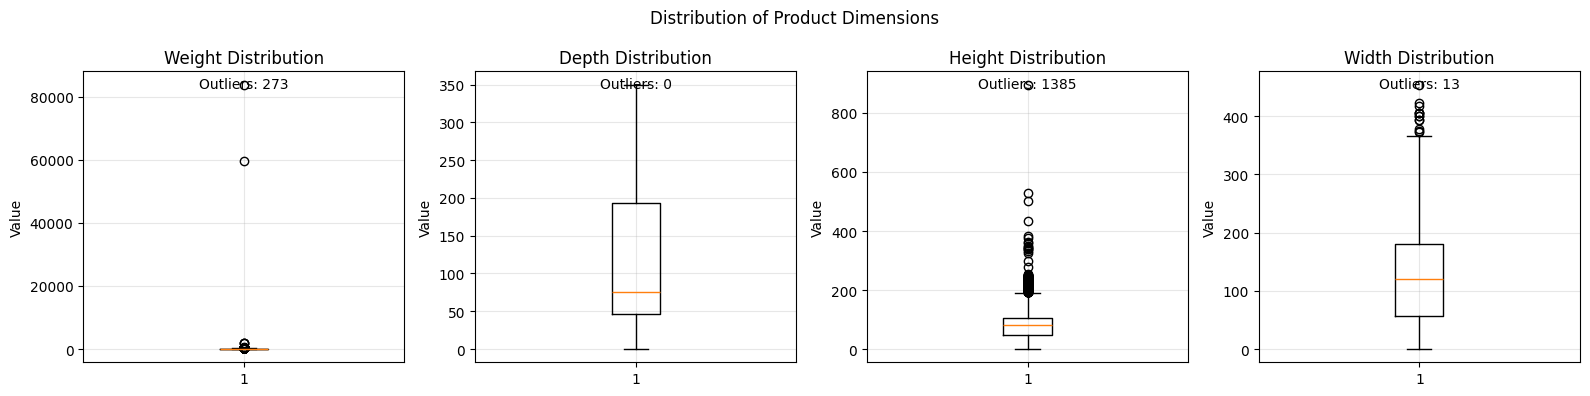

In [19]:

# Step 3.2.2: Plot weight, depth, height, weight to check for outliers

# Convert columns to numeric, handling any non-numeric values
dimensions = ['weight', 'depth', 'height', 'width']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, dim in enumerate(dimensions):
    if dim in df_wide.columns:
        # Convert to numeric, converting errors to NaN
        numeric_data = pd.to_numeric(df_wide[dim], errors='coerce')
        
        # Remove NaN values for plotting
        clean_data = numeric_data.dropna()
        
        if len(clean_data) > 0:
            axes[idx].boxplot(clean_data)
            axes[idx].set_title(f'{dim.capitalize()} Distribution')
            axes[idx].set_ylabel('Value')
            axes[idx].grid(True, alpha=0.3)
            
            # Add outlier statistics
            Q1 = clean_data.quantile(0.25)
            Q3 = clean_data.quantile(0.75)
            IQR = Q3 - Q1
            outliers = clean_data[(clean_data < Q1 - 1.5 * IQR) | (clean_data > Q3 + 1.5 * IQR)]
            axes[idx].text(0.5, 0.98, f'Outliers: {len(outliers)}', 
                          transform=axes[idx].transAxes, ha='center', va='top')

plt.suptitle('Distribution of Product Dimensions')
plt.tight_layout()
plt.show()

In [20]:

# Step 3.2.3: Clean data

# ---- WEIGHT ----
# list top 10 row with heighest weight
_weight_num = pd.to_numeric(df_wide['weight'], errors='coerce')
top10_heaviest = (
    df_wide.assign(weight_num=_weight_num)
           .sort_values('weight_num', ascending=False)
           .head(10)
           [['item_code', 'product_name', 'weight', 'weight_num', 'dimensionDetail']]
)
top10_heaviest

# clean the outliers by dividing by 1000 and rounding up if weight > 600
weight_clean = _weight_num.copy()
mask_scale = weight_clean > 600
# Scale and ceil
weight_clean.loc[mask_scale] = (weight_clean.loc[mask_scale] / 1000).apply(math.ceil)

# Attach cleaned weights to main dataframe
df_wide['weight_clean'] = weight_clean

# Recreate top 10 with cleaned weights
top10_heaviest_clean = (
    df_wide.assign(weight_num=_weight_num, weight_clean=weight_clean)
           .sort_values('weight_num', ascending=False)
           .head(10)
           [['item_code', 'product_name', 'weight', 'weight_num', 'weight_clean', 'dimensionDetail']]
)

# add unit to the cleaned weight, if value is not missing, before returning the cleaned column.
df_wide['weight_clean'] = df_wide['weight_clean'].apply(lambda x: f"{x} kg" if pd.notna(x) else x)

df_wide

,item_code,product_name,color,colorDetail,colorSubcolor,deliveryScope,depth,dimensionDetail,hasElectricItem,height,...,non_null_attribute_count,non_null_attribute_pct,weight_clean_num,weight_clean,height_clean_num,height_clean,width_clean_num,width_clean,depth_clean_num,depth_clean
0,000000001000000262,Wandleuchte Sally- Metall/Glas,Silber,"Hauptfarbe: Silber, Weiß Sekundärfarbe: Weiß",NaN,NaN,15,Breite: 82 cm Gewicht: 1.27 kg Höhe variabel: ...,1,NaN,...,12,80.00,1.27,1.27 kg,NaN,NaN,82.0,82 cm,15.0,15 cm
1,000000001000000450,Deckenleuchte Loona,Silber,Gestell: Silber,NaN,NaN,14,Durchmesser: 19 cm Gewicht: 0.64 kg Höhe varia...,1,NaN,...,11,73.33,0.64,0.64 kg,NaN,NaN,NaN,NaN,14.0,14 cm
2,000000001000001965,Glas-Pendelleuchte,Multicolor,NaN,NaN,NaN,8,"Höhe 110cm, Breite 41cm, Tiefe 8cm",1,110,...,11,73.33,1.80,1.8 kg,110.0,110 cm,41.0,41 cm,8.0,8 cm
3,000000001000001975,Porzellan-Pendelleuchte,Weiß,NaN,NaN,NaN,NaN,"Höhe 21cm, Durchmesser 29cm",1,21,...,9,60.00,1.80,1.8 kg,21.0,21 cm,NaN,NaN,NaN,NaN
4,000000001000002535,Deckenleuchten Balken II,Silber,Nickel,NaN,NaN,9,Breite: 48 cm Gewicht: 0.9 kg Höhe: 15 cm Tief...,1,15,...,13,86.67,0.90,0.9 kg,15.0,15 cm,48.0,48 cm,9.0,9 cm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9766,000000003001604996,Spielzelt 3013992,Grau,"Grau, Hellgrün, Weiß",Grau,"1 x Spielzelt & 550 x Ball (Gelb, Blau, Rot, W...",123,Breite: 120 cm Gewicht: 3.56 kg Höhe: 126 cm T...,0,126,...,14,93.33,3.56,3.56 kg,126.0,126 cm,120.0,120 cm,123.0,123 cm
9767,000000003001605008,Spielzelt 93680,Pink,Pink,Pink,1 x Spielzelt & 1 x Tragetasche,100,Breite: 100 cm Gewicht: 1.15 kg Höhe: 127 cm T...,0,127,...,14,93.33,1.15,1.15 kg,127.0,127 cm,100.0,100 cm,100.0,100 cm
9768,000000003001605792,Delfin Spielzeug 296178,Grau,Grau,Grau,1 x Delfin Spielzeug,100,Breite: 1 cm Gewicht: 1 kg Höhe: 40 cm Tiefe: ...,0,40,...,14,93.33,1.00,1.0 kg,40.0,40 cm,1.0,1 cm,100.0,100 cm
9769,000000003001605862,Esszimmerstuhl drehbar Jelena(6er Set),Grau,"Dunkelgrau, Grau",Dunkelgrau,6x Esszimmerstuhl 1x Montagezubehör\n1x Montag...,55,Armlehnenhöhe: 63 cm Belastbarkeit: 150 kg Bre...,0,83,...,15,100.00,57.00,57.0 kg,83.0,83 cm,59.0,59 cm,55.0,55 cm


In [21]:
# ---- HEIGHT ----
# list top 10 tallest products
height_num = pd.to_numeric(df_wide.get('height'), errors='coerce')

top10_tall = (
    df_wide.assign(height_num=height_num)
           .sort_values('height_num', ascending=False)
           .head(10)[['item_code', 'product_name', 'height', 'height_num', 'dimensionDetail']]
)


print("Top 10 tallest products")
display(top10_tall)

# clean the tallest by dividing by 10 and rounding up if height > 300
height_clean = height_num.copy()
mask_height_scale = height_clean >= 300
height_clean.loc[mask_height_scale] = (height_clean.loc[mask_height_scale] / 10).apply(math.ceil)
df_wide['height_clean'] = height_clean

top10_tall_clean = (
    df_wide.assign(height_num=height_clean)
           .sort_values('height_num', ascending=False)
           .head(10)[['item_code', 'product_name', 'height', 'height_num', 'height_clean', 'dimensionDetail']]
)

# Add unit cm to cleaned height
df_wide['height_clean'] = df_wide['height_clean'].apply(lambda x: f"{x} cm" if pd.notna(x) else x)

# ---- WIDTH ----
# list top 10 widest products
width_num = pd.to_numeric(df_wide.get('width'), errors='coerce')

top10_wide = (
    df_wide.assign(width_num=width_num)
           .sort_values('width_num', ascending=False)
           .head(10)[['item_code', 'product_name', 'width', 'width_num', 'dimensionDetail']]
)

print("Top 10 widest products")
display(top10_wide)

width_clean = width_num.copy()
mask_width_scale = width_clean >= 500  
width_clean.loc[mask_width_scale] = (width_clean.loc[mask_width_scale] / 10).apply(math.ceil)

df_wide['width_clean'] = width_clean

top10_wide_clean = (
    df_wide.assign(width_num=width_clean)
           .sort_values('width_num', ascending=False)
           .head(10)[['item_code', 'product_name', 'width', 'width_num', 'width_clean', 'dimensionDetail']]
)

# Add unit to cleaned width
df_wide['width_clean'] = df_wide['width_clean'].apply(lambda x: f"{x} cm" if pd.notna(x) else x)




# ---- DEPTH ----
# list top 10 deepest products
depth_num = pd.to_numeric(df_wide.get('depth'), errors='coerce')

top10_deep = (
    df_wide.assign(depth_num=depth_num)
           .sort_values('depth_num', ascending=False)
           .head(10)[['item_code', 'product_name', 'depth', 'depth_num', 'dimensionDetail']]
)
print("Top 10 deepest products")
display(top10_deep)

# clean the deepest by dividing by 10 and rounding up if depth >= 200 (likely mm captured as cm)
depth_clean = depth_num.copy()
mask_depth_scale = depth_clean >= 200
depth_clean.loc[mask_depth_scale] = (depth_clean.loc[mask_depth_scale] / 10).apply(math.ceil)

df_wide['depth_clean'] = depth_clean

top10_deep_clean = (
    df_wide.assign(depth_num=depth_clean)
           .sort_values('depth_num', ascending=False)
           .head(10)[['item_code', 'product_name', 'depth', 'depth_num', 'depth_clean', 'dimensionDetail']]
)

# Add unit to cleaned depth
df_wide['depth_clean'] = df_wide['depth_clean'].apply(lambda x: f"{x} cm" if pd.notna(x) else x)  


Top 10 tallest products


,item_code,product_name,height,height_num,dimensionDetail
4946,000000003000842340,Anhänger Orazio,895,895.0,Breite: 5 cm Gewicht: 5 kg Höhe: 895 cm Tiefe:...
4958,000000003000843226,Anhänger Mambo,527,527.0,Breite: 32 cm Durchmesser: 32 cm Gewicht: 0.83...
1630,000000001000427191,Pendelleuchte Plug & Shine Mapalo,500,500.0,Breite: 30 cm Gewicht: 0.66 kg Höhe: 500 cm Ti...
2785,000000003000318578,Kronleuchter CANDELA 3,435,435.0,Breite: 123 cm Gewicht: 0.1 kg Höhe: 435 cm Ma...
6762,000000003001132106,Pendelleuchte Mood,382,382.0,Breite: 10 cm Durchmesser: 20 cm Gewicht: 1.01...
6393,000000003001069800,Pendelleuchte Golden Cage,376,376.0,Breite: 7 cm Durchmesser: 14 cm Gewicht: 2.3 k...
6766,000000003001132162,Pendelleuchte Ros,363,363.0,Breite: 8 cm Durchmesser: 16 cm Gewicht: 0.9 k...
6765,000000003001132135,Pendelleuchte Nebula,360,360.0,Breite: 13 cm Durchmesser: 25 cm Gewicht: 1.4 ...
6764,000000003001132127,Pendelleuchte Kyoto,350,350.0,Breite: 11 cm Durchmesser: 22 cm Gewicht: 2 kg...
6831,000000003001143673,Pendelleuchte Pro Shade,345,345.0,Breite: 2 cm Durchmesser: 3 cm Gewicht: 0.62 k...


Top 10 widest products


,item_code,product_name,width,width_num,dimensionDetail
8577,000000003001360401,Kinosofa 4-Sitzer SALENTO,454,454.0,Belastbarkeit: 480 kg Breite: 454 cm Gewicht: ...
8571,000000003001360267,Kinosofa 4-Sitzer GALA,422,422.0,Belastbarkeit: 480 kg Breite: 422 cm Gewicht: ...
8582,000000003001360478,Kinosofa 4-Sitzer SALENTO,418,418.0,Belastbarkeit: 480 kg Breite: 418 cm Gewicht: ...
284,000000001000154844,Drehtürenschrank SKØP pure gloss,405,405.0,Breite: 405 cm Höhe: 222 cm Tiefe: 60 cm Innen...
279,000000001000154721,Schwebetürenschrank SKØP pure gloss,405,405.0,Breite: 405 cm Höhe: 236 cm Tiefe: 68 cm Innen...
861,000000001000303288,Schwebetürenschrank SKØP pure reflect,405,405.0,Breite: 405 cm Gewicht: 292.43 kg Höhe: 222 cm...
722,000000001000267525,Drehtürenschrank Livorno I,400,400.0,Breite: 400 cm Gewicht: 321.1 kg Höhe: 236 cm ...
732,000000001000269849,Drehtürenschrank Barcelona VI,400,400.0,Breite: 400 cm Gewicht: 349.6 kg Höhe: 236 cm ...
8564,000000003001360137,Kinosofa 3-Sitzer SALENTO,394,394.0,Belastbarkeit: 360 kg Breite: 394 cm Gewicht: ...
2045,000000001000468735,Drehtürenschrank Cardiff - Glastür A,393,393.0,Breite: 393 cm Gewicht: 317.3 kg Höhe: 216 cm ...


Top 10 deepest products


,item_code,product_name,depth,depth_num,dimensionDetail
2806,000000003000330117,Pendelleuchte Hang 5,350,350.0,Breite: 5 cm Durchmesser: 12 cm Gewicht: 1.5 k...
7048,000000003001173191,modulares Sofa LUPINE 5 Sitzplätze,335,335.0,Armlehnenhöhe: 70 cm Belastbarkeit: 450 kg Bre...
6917,000000003001152709,modulares Sofa LUPINE 5 Sitzplätze,335,335.0,Armlehnenhöhe: 70 cm Belastbarkeit: 450 kg Bre...
6923,000000003001152849,Sofa MILEY 4 Sitzplätze,323,323.0,Armlehnenhöhe: 63 cm Belastbarkeit: 450 kg Bre...
6902,000000003001151129,Sofa MILEY 4 Sitzplätze,323,323.0,Armlehnenhöhe: 63 cm Belastbarkeit: 450 kg Bre...
6901,000000003001151115,Sofa MILEY 4 Sitzplätze,323,323.0,Armlehnenhöhe: 63 cm Belastbarkeit: 450 kg Bre...
6980,000000003001161637,Sofa MILEY 4 Sitzplätze,323,323.0,Armlehnenhöhe: 63 cm Belastbarkeit: 450 kg Bre...
6758,000000003001130919,TV Lowboard TV Schrank Fernsehschrank02,320,320.0,Breite: 41 cm Gewicht: 29.5 kg Höhe: 30 cm Tie...
4334,000000003000692805,Ecksofa Eckcouch Kiev Couch,312,312.0,Breite: 90 cm Gewicht: 67 kg Höhe: 85 cm Tiefe...
1161,000000001000370775,Esstisch Trelleborg II,300,300.0,Belastbarkeit: 50 kg Breite: 100 cm Gewicht: 7...


In [22]:
# Step 3.3: material, materialDetail
# Rows where material is present but materialDetail is missing
mask_material_no_detail = df_wide['material'].notna() & df_wide['materialDetail'].isna()
material_missing_detail = (
    df_wide.loc[mask_material_no_detail, ['item_code', 'product_name', 'material', 'materialDetail']]
)

count_missing = len(material_missing_detail)
print(f"Products with material but no materialDetail: {count_missing} ({count_missing / len(df_wide):.2%})")

# Show a sample
material_missing_detail.head(10)

Products with material but no materialDetail: 0 (0.00%)


,item_code,product_name,material,materialDetail


In [23]:
# Rows where materialDetail is present but material is missing
mask_detail_no_material = df_wide['materialDetail'].notna() & df_wide['material'].isna()
material_detail_no_material = df_wide.loc[mask_detail_no_material, ['item_code', 'product_name', 'material', 'materialDetail']]

print(f"Products with materialDetail but no material: {len(material_detail_no_material)} "
    f"({len(material_detail_no_material) / len(df_wide):.2%})")

material_detail_no_material.head(20)

Products with materialDetail but no material: 63 (0.64%)


,item_code,product_name,material,materialDetail
94,000000001000070256,Pendelleuchte Tepsa,NaN,Silikon
101,000000001000072986,LED-Deckenleuchte Sileda I,NaN,Hauptmaterial: Eisen
1287,000000001000388764,3-Sitzer Sofa KEDRO,NaN,Lederart: Pigmentiertes Leder
1294,000000001000391411,Pendelleuchte Weald,NaN,Glasart: Rauchglas Metallart: Eisen Oberfläche...
1295,000000001000391422,Deckenleuchte Grove,NaN,Metallart: Eisen Oberfläche Metall: Lackiert S...
1312,000000001000393880,Big-Sofa Jampaw,NaN,Lederart: Echtleder
1352,000000001000400668,Armlehnenstuhl NICHOLAS,NaN,"Sitzbezug: Bouclé Beine: Massivholz Eiche, geölt"
1383,000000001000403171,2-Sitzer Sofa MAISON,NaN,Stoffart: Cord
1462,000000001000410748,2-Sitzer Sofa Luro,NaN,Stoffart: Webstoff
1550,000000001000421499,Polsterbett KINX,NaN,Stoffart: Flachgewebe


In [24]:
# Step 4: Parsing and formatting

SECTION_NAME_MAPPING = {
    'de': 'Allgemein',
    'en': 'General'
}

ATTRIBUTE_NAME_MAPPING = {
    'shippingCondition': 'Lieferzustand',
    'styleFilter': 'Stil',
    'guarantee': 'Garantie (Jahre)',
    'weight_clean': 'Gewicht',
    'depth_clean': 'Tiefe',
    'height_clean': 'Höhe',
    'width_clean': 'Breite',
    'materialDetail': 'Material',
    'colorDetail': 'Farbe'
}

lang = 'de'


# pasrsing materialDetail or colorDetail into product_detail format
# Format product detail string
def format_product_detail(raw_text: str, section_name: str, attribute_name: str) -> str:
    # Pattern: capture simple key:value pairs. Stops before next key or end of string.
    pattern = r'(\w+):\s*([^:]+?)(?=\s+\w+:|$)'
    matches = list(re.finditer(pattern, raw_text))
    out = []
    if matches:
        # Anything before first key:value pair is treated as a free text intro
        first_start = matches[0].start()
        leading = raw_text[:first_start].strip()
        if leading:
            out.append(f"{section_name}:{attribute_name}:{leading}")
        for m in matches:
            k, v = m.group(1), m.group(2).strip()
            # Quote values that contain commas so they remain grouped when later parsed
            if ',' in v:
                v = f'"{v}"'
            out.append(f"{attribute_name}:{k}:{v}")
    else:
        # No structured pairs, keep whole string as a single line
        out.append(f"{section_name}:{attribute_name}:{raw_text.strip()}")
    return ",".join(out)


raw = "Hauptmaterial: Metall Sekundärmaterial Kunststoff"
print(format_product_detail(raw, SECTION_NAME_MAPPING['de'], ATTRIBUTE_NAME_MAPPING['materialDetail']))

Material:Hauptmaterial:Metall Sekundärmaterial Kunststoff


In [25]:
# Select marketing relevant columns to keep, classify into 3 groups
selected_general = ['shippingCondition', 'styleFilter', 'guarantee']
selected_dimensions = ['weight_clean', 'depth_clean', 'height_clean', 'width_clean']
selected_need_parsing = ['materialDetail', 'colorDetail']

selected_col = ['materialDetail', 
                'colorDetail',
                'weight_clean', 
                'depth_clean', 
                'height_clean', 
                'width_clean',
                'styleFilter',
                'shippingCondition',
                'guarantee',
                ]

# Build list of columns to keep
selected_orig_keys = selected_col
keep_cols = ['item_code'] + selected_col

# Preserve order, remove duplicates, and only keep those actually present
seen = set()
keep_cols = [c for c in keep_cols if (c in df_wide.columns and not (c in seen or seen.add(c)))]

# Subset
df_selected = df_wide[keep_cols]

print(f"Keeping {len(keep_cols)} columns")
df_selected.head()



Keeping 9 columns


,item_code,materialDetail,colorDetail,weight_clean,depth_clean,height_clean,width_clean,styleFilter,shippingCondition
0,000000001000000262,Hauptmaterial: Metall Sekundärmaterial Glas,"Hauptfarbe: Silber, Weiß Sekundärfarbe: Weiß",1.27 kg,15.0 cm,NaN,82.0 cm,Modern,Montiert
1,000000001000000450,Gestell: Edelstahl,Gestell: Silber,0.64 kg,14.0 cm,NaN,NaN,Modern,Montiert
2,000000001000001965,"Metall, Glas",NaN,1.8 kg,8.0 cm,110.0 cm,41.0 cm,Andere,NaN
3,000000001000001975,Porzellan,NaN,1.8 kg,NaN,21.0 cm,NaN,Modern,NaN
4,000000001000002535,Metall,Nickel,0.9 kg,9.0 cm,15.0 cm,48.0 cm,Modern,Montiert


In [26]:
# Create product_detail column combining non-missing selected_general fields

df_selected = df_selected.copy()


def _build_product_detail(row):
    section_name = SECTION_NAME_MAPPING[lang]
    parts = []
    for col in selected_col:
        if col in df_selected.columns:
            v = row.get(col)
            if pd.notna(v):
                attr_name = ATTRIBUTE_NAME_MAPPING.get(col, col)
                parts.append(format_product_detail(str(v).strip(), section_name, attr_name))
    return ",".join(parts) if parts else None

df_selected['product_detail'] = df_selected.apply(_build_product_detail, axis=1)

df_selected
    

,item_code,materialDetail,colorDetail,weight_clean,depth_clean,height_clean,width_clean,styleFilter,shippingCondition,product_detail
0,000000001000000262,Hauptmaterial: Metall Sekundärmaterial Glas,"Hauptfarbe: Silber, Weiß Sekundärfarbe: Weiß",1.27 kg,15.0 cm,NaN,82.0 cm,Modern,Montiert,Material:Hauptmaterial:Metall Sekundärmaterial...
1,000000001000000450,Gestell: Edelstahl,Gestell: Silber,0.64 kg,14.0 cm,NaN,NaN,Modern,Montiert,"Material:Gestell:Edelstahl,Farbe:Gestell:Silbe..."
2,000000001000001965,"Metall, Glas",NaN,1.8 kg,8.0 cm,110.0 cm,41.0 cm,Andere,NaN,"Allgemein:Material:Metall, Glas,Allgemein:Gewi..."
3,000000001000001975,Porzellan,NaN,1.8 kg,NaN,21.0 cm,NaN,Modern,NaN,"Allgemein:Material:Porzellan,Allgemein:Gewicht..."
4,000000001000002535,Metall,Nickel,0.9 kg,9.0 cm,15.0 cm,48.0 cm,Modern,Montiert,"Allgemein:Material:Metall,Allgemein:Farbe:Nick..."
...,...,...,...,...,...,...,...,...,...,...
9766,000000003001604996,"Material: Metall, Textil Metallart: Stahl Stof...","Grau, Hellgrün, Weiß",3.56 kg,123.0 cm,126.0 cm,120.0 cm,NaN,Zerlegt,"Material:Material:""Metall, Textil"",Material:Me..."
9767,000000003001605008,Material: Textil Stoffart: Polyester,Pink,1.15 kg,100.0 cm,127.0 cm,100.0 cm,NaN,Teilmontiert,"Material:Material:Textil,Material:Stoffart:Pol..."
9768,000000003001605792,Material: Textil Stoffart: Polyester,Grau,1.0 kg,100.0 cm,40.0 cm,1.0 cm,NaN,Keine Montage erforderlich,"Material:Material:Textil,Material:Stoffart:Pol..."
9769,000000003001605862,"Material: Metall, Textil Muster: Kariert Oberf...","Dunkelgrau, Grau",57.0 kg,55.0 cm,83.0 cm,59.0 cm,Modern,Zerlegt,"Material:Material:""Metall, Textil"",Material:Mu..."


In [27]:

# Step 5: Exporting .csv
# Save only item_code and product_detail, rename item_code to sku, and export to CSV

export_df = (
    df_selected[['item_code', 'product_detail']]
    .rename(columns={'item_code': 'sku'})
)
output_path = Path('product_detail.csv')
export_df.to_csv(output_path, index=False)